# SchW-BERT-GAN ファインチューニング
- 事前学習済みのモデルを使用したSchW-BERT-GAN用のモジュールの定義
    - body選択
    - SchwBertGenerator
    - SchwBertDiscriminator
- SchW-BERT-GANのファインチューニングの実施
    - ファインチューニング用関数を作成
    - 事前学習済みのものと比較
- SchW-BERT-GANによる音楽自動生成
    - バンドルをデータセットからランダムに選んできて生成

WGAN-gpの実装は[eriklindernoren/PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py)が参考になる  
他にもいろいろPytorchのGANが実装されてる

In [1]:
import os, glob, copy, time, math
visible_devices = [2, 3]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.normalization import LayerNorm
from torch.utils.data import random_split
from pytorch_memlab import MemReporter
from multiprocessing import Pool, cpu_count
from pypianoroll import Track, Multitrack
from attrdict import AttrDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from utils import Timer, count_params, grad_status, grid_plot
from bundle import Bundle
from preprocess.original import load_bundle_list
from dataloader import TheorytabDataset, TheorytabDataLoader
from modules.model import save_body, load_body, make_body
from modules.multi_gpu import MultiGPUWrapper
from modules.save_and_load import save_config, load_config, save_model, load_model

core_num = 20
print(f"{core_num}/{cpu_count()} cpus are available.")

current dir: /root/schwbert
20/32 cpus are available.


In [2]:
base_dir = "../datasets"
schwbert_dir = os.path.join(base_dir, "schwbert")

dataset_dir = os.path.join(base_dir, "theorytab")
input_csv = os.path.join(dataset_dir, "theorytab.csv")
input_dir = os.path.join(dataset_dir, "pianoroll")

models_dir = os.path.join(schwbert_dir, "models", "theorytab")
pretrained_dir = os.path.join(models_dir, "pretrained")
finetuned_dir = os.path.join(models_dir, "finetuned")

for directory in [schwbert_dir, models_dir, pretrained_dir, finetuned_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

### Configのロード

In [3]:
def select_config(directory, postfix=".json", fixed_number=None):
    config_paths = glob.glob(os.path.join(directory, f"*{postfix}"))
    config_paths.sort()
    if len(config_paths) > 1:
        print(f"{len(config_paths)} models found in {directory}")
        for i, path in enumerate(config_paths):
            print(f"{i}: {path.split('/')[-1]}")
        if fixed_number is None:
            config_path = config_paths[int(input("input the number of config:"))]
        else:
            config_path = config_paths[fixed_number]
    else:
        config_path = config_paths[0]
    
    config_name = config_path.split('/')[-1]
    print(f"config is loaded from {config_name}")
    config = load_config(config_name, directory)
    return AttrDict(config)

In [4]:
config = select_config(pretrained_dir, fixed_number=0)
config.nickname = "schbertgan_small"
config.noise_size = 128
config.noise_fact_size = 0
config.g_lr = 5e-4
config.d_lr = 1e-6
config.adam_beta1 = 0.5
config.dtt = 2
config.gtt = 5
config.k = 5
config.max_gtt = 50
config.fm_lambda = 100
config.gp_lambda = 10
print(config)

3 models found in ../datasets/schwbert/models/theorytab/pretrained
0: schbert:config@2019-12-15_15:55.json
1: schbert_large:config@2019-12-15_14:41.json
2: schbert_mini:config@2019-12-15_21:36.json
config is loaded from schbert:config@2019-12-15_15:55.json
AttrDict({'nickname': 'schbertgan_small', 'step_num': 768, 'beat_resolution': 12, 'beats_in_bar': 4, 'bar_num': 16, 'include_rest_to_area': False, 'melody_pitch_range': [0, 24], 'melody_rest_id': 24, 'melody_mask_id': 25, 'melody_pad_id': 26, 'melody_vocab_size': 27, 'chord_pad_id': 12, 'chord_vocab_size': 13, 'fact_size': 16, 'hidden_size': 128, 'intermediate_size': 512, 'attention_layer_num': 2, 'attention_head_num': 1, 'share_all_bert_params': False, 'dropout_prob': 0.1, 'adam_lr': 5e-05, 'adam_beta1': 0.5, 'adam_beta2': 0.999, 'pre_mnp_aug': 4, 'pre_msp_aug': 2, 'pre_mnp_rate': 0.15, 'pre_mnp_mask_rate': 0.8, 'pre_mnp_random_rate': 0.1, 'pre_mnp_keep_rate': 0.1, 'state_names': {'embeddings': 'schbert:ConditionalEmbeddings:E=050H=

### データのロード

In [5]:
with Timer():
     bundle_list = load_bundle_list(input_csv, input_dir, core_num=core_num)

dataset = TheorytabDataset(bundle_list)

start preprocessing...
unpacking result bundles list...
Preprocessing Finished!
load 17396 bundles
0 error(s) occured
Timer: 23.439329


Process ForkPoolWorker-5:
Process ForkPoolWorker-9:
Process ForkPoolWorker-18:
Process ForkPoolWorker-7:
Process ForkPoolWorker-16:
Process ForkPoolWorker-12:
Process ForkPoolWorker-2:
Process ForkPoolWorker-11:
Process ForkPoolWorker-4:
Process ForkPoolWorker-8:
Process ForkPoolWorker-10:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-20:
Process ForkPoolWorker-14:
Process ForkPoolWorker-3:
Process ForkPoolWorker-13:
Process ForkPoolWorker-19:
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/root/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/root/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent 

  File "/root/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/root/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/root/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/root/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/root/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/root/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/root/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/root/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/root/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/queues.py", li

In [6]:
dataloader = TheorytabDataLoader(dataset, batch_size=2, shuffle=True)
print(len(dataloader))

8698


# SchW-BERT-GAN用のモジュールの定義
- SchwBertGenerator*
    - NoiseEmbedding*
        - ノイズベクトルシーケンス→Dense
    - ConditionalBertBody
    - Denseをかけ，メロディを出力
- SchwBertDiscriminator*
    - ConditionalBertBody
    - Denseを縦横にかけ，本物と偽物を区別するよう2値分類

✳︎ついてるやつが新規作成モジュール

## 各種Embeddingsの実装
- (batch_size, noise_size)のノイズを作成
- ノイズをLinearで(batch_size, step_num\*hidden_size)に展開
- 展開したノイズを(batch_size, step_num, hidden_size)に変形
- LayerNormでステップごとにノイズを正規化
- padのステップを0にする

In [7]:
class NoiseEmbedding(nn.Module):
    def __init__(self, config, fact=True, padding=True):
        super(NoiseEmbedding, self).__init__()
        self.config = config
        self.noise_size = config.noise_size
        self.pad_id = config.chord_pad_id if padding else None
        self.noise_fact_size = config.get('noise_fact_size', 0)
        self.step_num = config.step_num
        self.hidden_size = config.hidden_size
        output_size = self.step_num * self.hidden_size
        
        if fact and self.noise_fact_size > 0:
            self.embedding = nn.Sequential(
                nn.Linear(self.noise_size, self.noise_fact_size, bias=False),
                nn.Linear(self.noise_fact_size, output_size, bias=False)
            )
        else:
            self.embedding = nn.Linear(self.noise_size, output_size, bias=False)
            
        self.norm = LayerNorm(self.hidden_size, eps=1e-12)
    
    def forward(self, input_ids, device=None, get_noise=False):
        # input_tesorはサイズの取得とPadding用(なのでchordを使う)
        if device is None:
            device = input_ids.device
        batch_size, seq_len, _ = input_ids.shape
        
        # ノイズを作成
        noise_vec = torch.randn(batch_size, self.noise_size)
        noise_vec = noise_vec.to(device)

        # ノイズを展開し，変形
        embedding = self.embedding(noise_vec)
        embedding = embedding.view(batch_size, self.step_num, self.hidden_size)
        embedding = self.norm(embedding)
        
        # padding
        if self.pad_id is not None:
            is_not_pad = (input_ids[:, :, self.pad_id] == 0).unsqueeze(-1)
            embedding = embedding * is_not_pad
                
        if get_noise:
            return embedding, noise_vec_seq
        else:
            return embedding

動作確認

In [14]:
batch = dataloader()
noise_embedding = NoiseEmbedding(config)

with Timer("Noise Total"):
    noise_emb = noise_embedding(batch.chord)

print("noise_embedding shape:", noise_emb.shape)
print("first step of the embedding\n", noise_emb[0][0])
print("last step of the embedding\n", noise_emb[0][-1])

Noise Total: 0.001635
noise_embedding shape: torch.Size([2, 768, 128])
first step of the embedding
 tensor([-0.0260, -0.8823, -0.1065,  0.4843, -0.1778,  1.3673, -0.4154,  0.7273,
         0.8263, -0.2097,  1.0297,  1.2703, -1.1935, -0.7079, -1.5160,  0.3632,
         0.1958, -1.4206,  0.5049, -1.1209,  0.8844,  0.2139, -1.0111, -0.1614,
        -0.0516,  0.2130, -0.3768,  1.2718,  0.7711, -1.3616,  1.0097,  0.7049,
         0.4957, -0.8806,  2.4181, -0.1556, -0.2623, -1.2558,  0.3439, -0.4134,
        -1.3276, -0.7987, -0.2859, -0.3170,  0.5128,  0.0739,  0.8675,  0.5994,
        -1.7832,  1.3692,  1.1586,  0.1234, -0.0842,  0.2283, -0.6776,  0.3755,
         1.2091, -0.5218, -1.6234, -0.8314, -1.6401, -0.6063, -1.2136,  0.4961,
         0.5317, -1.5970,  0.7527, -2.5002,  1.4967,  0.6575, -1.5651,  0.6495,
        -1.0914, -1.0584, -0.5672, -0.1999,  0.3811, -0.1182,  2.3975, -2.1858,
         0.5053,  1.3046, -0.0062,  1.7499,  0.9747, -0.9117, -0.3863,  0.0186,
        -0.3171,  0.

In [15]:
count_params(noise_embedding.embedding)

1574912

全てのステップで同じノイズを用いるStepWiseNoiseEmbeddingを実装してみる

In [8]:
class StepWiseNoiseEmbedding(nn.Module):
    def __init__(self, config, fact=True, padding=True):
        super(StepWiseNoiseEmbedding, self).__init__()
        self.config = config
        self.noise_size = config.noise_size
        self.pad_id = config.chord_pad_id if padding else None
        self.noise_fact_size = config.get('noise_fact_size', 0)
        self.step_num = config.step_num
        self.hidden_size = config.hidden_size
        
        if fact and self.noise_fact_size > 0:
            self.embedding = nn.Sequential(
                nn.Linear(self.noise_size, self.noise_fact_size, bias=False),
                nn.Linear(self.noise_fact_size, self.hidden_size, bias=False)
            )
        else:
            self.embedding = nn.Linear(self.noise_size, self.hidden_size, bias=False)
            
        self.norm = LayerNorm(self.hidden_size, eps=1e-12)
    
    def forward(self, input_ids, device=None, get_noise=False):
        # input_tesorはサイズの取得とPadding用(なのでchordを使う)
        if device is None:
            device = input_ids.device
        batch_size, seq_len, _ = input_ids.shape
        
        # ノイズを作成
        noise_vec = torch.randn(batch_size, 1, self.noise_size)
        noise_vec = noise_vec.expand(batch_size, seq_len, self.noise_size)
        noise_vec = noise_vec.to(device)

        # forward
        embedding = self.embedding(noise_vec)
        embedding = self.norm(embedding)
        
        # padding
        if self.pad_id is not None:
            is_not_pad = (input_ids[:, :, self.pad_id] == 0).unsqueeze(-1)
            embedding = embedding * is_not_pad
                
        if get_noise:
            return embedding, noise_vec_seq
        else:
            return embedding

動作確認

In [9]:
batch = dataloader()
noise_embedding = StepWiseNoiseEmbedding(config)

with Timer("Noise Total"):
    noise_emb = noise_embedding(batch.chord)

print("noise_embedding shape:", noise_emb.shape)
print("first step of the embedding\n", noise_emb[0][0])
print("last step of the embedding\n", noise_emb[0][-1])

Noise Total: 0.005112
noise_embedding shape: torch.Size([2, 768, 128])
first step of the embedding
 tensor([ 0.2414,  1.2853, -1.0197,  0.7286, -0.1162, -1.3347, -1.7025, -0.8576,
         0.1427, -1.1403, -0.9936, -1.5911,  2.3323,  1.4159,  0.8012, -1.5543,
         1.7593, -0.5046,  0.8418, -1.3623, -1.2925,  1.0777,  0.6578, -0.3761,
         1.4479, -1.3648,  0.7314, -0.6756, -0.5890, -0.2137, -0.3153,  0.0069,
         0.2701, -0.8549, -0.8241,  0.9282,  0.6045, -1.6538, -1.6210, -0.7108,
         0.3286, -1.1075, -0.3885,  2.2257,  1.6856,  0.7565, -0.1858,  0.9314,
         0.3114, -1.2581,  0.2251,  0.0599, -0.9020, -0.2104, -0.7986, -0.1491,
         0.1136, -1.0931,  0.3668,  0.9026,  0.0626,  0.7186, -0.9340,  0.3348,
         1.6687,  0.1311,  0.1480, -0.0214,  0.1308, -1.0390,  1.1925, -0.0989,
        -1.0871, -0.8561,  1.2088, -0.1986,  1.4267,  0.6228,  0.4738,  0.6945,
         1.1312,  0.1202,  0.0843,  0.3160, -1.3508,  1.0925, -1.8490,  2.5577,
         0.5579, -0.

In [10]:
count_params(noise_embedding.embedding)

16384

## SchWBertGeneratorの実装
メロディについてのembeddingsモジュールをnoiseに置き換える

In [9]:
class SchWBertGenerator(nn.Module):
    def __init__(self, config, body, padding=True):
        super(SchWBertGenerator, self).__init__()
        self.config = config
        self.pad_id = config.melody_pad_id if padding else None
        self.condition_pad_id = config.chord_pad_id if padding else None
        self.melody_vocab_size = config.melody_vocab_size
        self.to_one_hot = torch.eye(self.melody_vocab_size, dtype=torch.long)
         
        self.body = body
        self.body.embeddings.input_embedding = NoiseEmbedding(config)
        
        self.head = nn.Sequential(
            nn.Linear(config.hidden_size, config.melody_vocab_size),
            nn.LeakyReLU(0.2)
        )
        
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, condition_tensor, get_all_outputs=False, get_probs=False):
        if get_probs:
            body_output, probs = self.body(condition_tensor, condition_tensor, get_all_outputs, get_probs)
        else:
            body_output = self.body(condition_tensor, condition_tensor, get_all_outputs, get_probs)
        
        if get_all_outputs:
            output = body_output[-1]
        else:
            output = body_output        
        
        output = self.head(output)
        
        if self.pad_id is not None:
            is_pad = (condition_tensor[:, :, self.condition_pad_id] == 1) * 10000
            output[:, :, self.pad_id] += is_pad
        
        output = self.softmax(output)
            
        if get_all_outputs:
            output = body_output + output
                
        if get_probs:
            return output, probs
        else:
            return output
        
    def to_melody(self, output_map):
        probs, preds = torch.max(output_map, dim=-1)
        preds = self.to_one_hot[preds].to(torch.float)
        return preds.numpy().astype(bool)

動作確認

In [15]:
batch = dataloader()

In [20]:
g_body = load_body(config, pretrained_dir)
# g_body = make_body(config)
G = SchWBertGenerator(config, g_body)

with Timer("G Total"):
    g_out = G(batch.chord)

print(g_out.shape)

G Total: 0.054793
torch.Size([2, 768, 27])


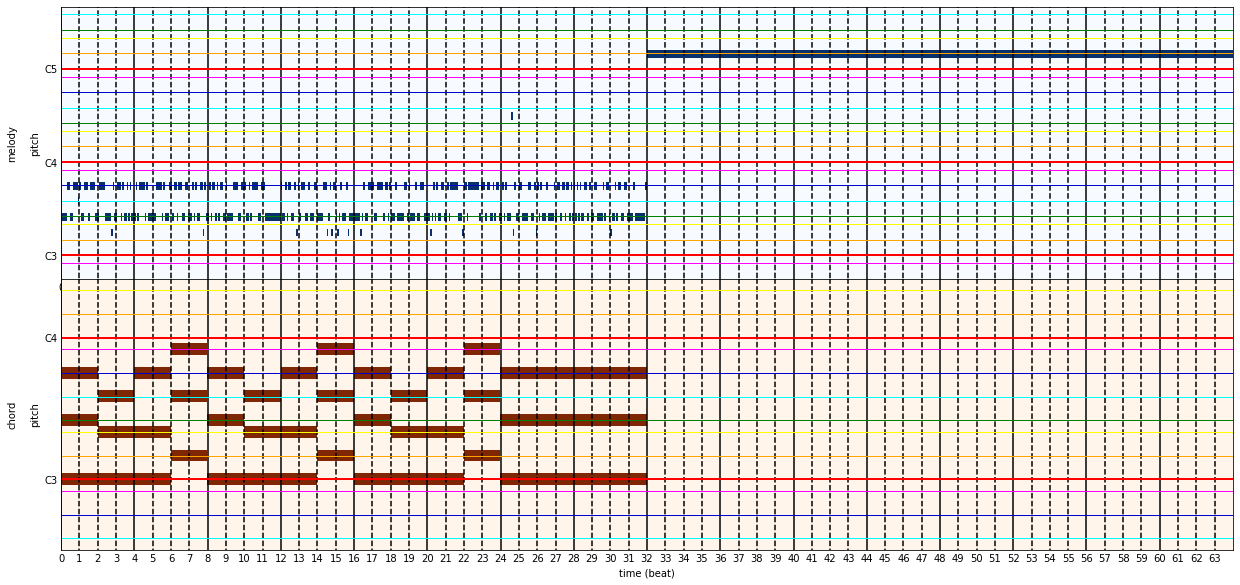

In [21]:
batch_id = 0

g_melody = G.to_melody(g_out)
bundle = Bundle({
    'melody': g_melody[batch_id],
    'chord': batch.chord[batch_id].numpy(),
    'meta': batch.meta[batch_id]
})
bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
ppr = bundle.get_ppr()
grid_plot(ppr, beat_resolution=bundle.meta.beat_resolution)

## SchWBertDiscriminatorの実装

In [10]:
class SchWBertDiscriminator(nn.Module):
    def __init__(self, config, body, light=False):
        super(SchWBertDiscriminator, self).__init__()
        self.config = config
        self.body = body
        
        # attentionを使わない軽量仕様
        if light:
            self.body.bert_stack.attention_list = None
        
        self.pad_id = config.chord_pad_id
        
        self.head = nn.Sequential(
            nn.Linear(config.hidden_size, 1),
            nn.LeakyReLU(0.2)
        )
        
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, input_tensor, condition_tensor, get_all_outputs=False, get_probs=False):
        if get_probs:
            body_output, probs = self.body(input_tensor, condition_tensor, get_all_outputs, get_probs)
        else:
            body_output = self.body(input_tensor, condition_tensor, get_all_outputs, get_probs)
        
        if get_all_outputs:
            output = body_output[-1]
        else:
            output = body_output

        output = self.head(output).squeeze()
        
        # paddingでないところのみを平均して出力を得る
        is_not_pad = (condition_tensor[:, :, self.pad_id] == 0)
        output = (output * is_not_pad).sum(-1) / is_not_pad.sum(-1)
        
        output_ans = self.sigmoid(output)
                
        if get_all_outputs:
            output = body_output + output
        
        if get_probs:
            return output_ans, output, probs
        else:
            return output_ans, output

動作確認

In [18]:
# d_body, g_body = make_body(config), make_body(config)
d_body, g_body = load_body(config, pretrained_dir), load_body(config, pretrained_dir)
G = SchWBertGenerator(config, g_body)
D = SchWBertDiscriminator(config, d_body)

batch = dataloader()

with Timer("D real"):
    d_out_real = D(batch.melody, batch.chord)

with Timer("G make fake"):
    fake = G(batch.chord)

with Timer("D fake"):
    d_out_fake = D(fake, batch.chord)

print("real:", d_out_real)
print("fake:", d_out_fake)

D real: 0.076211
G make fake: 0.067603
D fake: 0.063241
real: (tensor([0.5475, 0.5412], grad_fn=<SigmoidBackward>), tensor([0.1907, 0.1653], grad_fn=<DivBackward0>))
fake: (tensor([0.5238, 0.5268], grad_fn=<SigmoidBackward>), tensor([0.0951, 0.1074], grad_fn=<DivBackward0>))


In [19]:
D = SchWBertDiscriminator(config, d_body, light=True)

batch = dataloader()
with Timer("D light real"):
    d_out_real = D(batch.melody, batch.chord)

with Timer("G make fake"):
    fake = G(batch.chord)

with Timer("D light fake"):
    d_out_fake = D(fake, batch.chord)

print("real:", d_out_real)
print("fake:", d_out_fake)

D light real: 0.008562
G make fake: 0.048427
D light fake: 0.007817
real: (tensor([0.5449, 0.5026], grad_fn=<SigmoidBackward>), tensor([0.1802, 0.0105], grad_fn=<DivBackward0>))
fake: (tensor([0.5016, 0.4917], grad_fn=<SigmoidBackward>), tensor([ 0.0065, -0.0333], grad_fn=<DivBackward0>))


# SchW-BERT-GANのファインチューニングの実施
事前学習済みのものとの比較もやる

### 学習用データの作成

In [11]:
# batch_size = 70 # WGAN-gp
batch_size = 200
# batch_size = 150 # Light
dataloader = TheorytabDataLoader(dataset, batch_size=batch_size, shuffle=True)
print("data num:", len(dataloader.dataset))
print("batch num:", len(dataloader))

data num: 17396
batch num: 87


### モデルの用意

In [12]:
device = torch.device('cuda')
init_g_body = True
init_d_body = True
multi_gpu = (len(visible_devices) > 1) & (device.type == 'cuda') & True

if init_g_body:
    print("Use initialized body in G")
    g_body = make_body(config)
else:
    print("Use pre-trained body in G")
    g_body = load_body(config, pretrained_dir)
G = SchWBertGenerator(config, g_body)


if init_d_body:
    print("Use initialized body in D")
    d_body = make_body(config)
else:
    print("Use pre-trained body in D")
    d_body = load_body(config, pretrained_dir)
D = SchWBertDiscriminator(config, d_body, light=False)


G, D = G.to(device), D.to(device)


if multi_gpu:
    print("Use Multi GPUs")
    G, D = MultiGPUWrapper(G), MultiGPUWrapper(D)


g_optim = optim.Adam(G.parameters(), lr=config.g_lr, betas=(config.adam_beta1, config.adam_beta2))
d_optim = optim.Adam(D.parameters(), lr=config.d_lr, betas=(config.adam_beta1, config.adam_beta2))

print("Network settings completed")
print("#parameters of G:", count_params(G))
print("#parameters of D:", count_params(D))

Use initialized body in G
Use initialized body in D
Use Multi GPUs
Network settings completed
#parameters of G: 438299
#parameters of D: 421761


## Adaptive GTT GANによる訓練

In [13]:
def train_gan_adaptive(G, D, g_optim, d_optim, k, max_gtt, fm_lambda, dataloader, epoch_num, output_dir, device, adaptive=True,
              start_epoch=1, clear_disp_epoch_period=3, report_period=None, save_epoch_period=None, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    data_size = len(dataloader.dataset) // batch_size
    
    status_dict = { 
        'd_loss': [], 'd_ans_real': [], 'd_ans_fake': [], 
        'g_loss': [], 'g_loss_fake': [], 'g_loss_fm': [], 'gtt': [] 
    }
    
    G.train()
    D.train()

    try:        
        for epoch in range(start_epoch, epoch_num+1):
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            t_iter_start = time.time()
            
            # adaptive gtt: 本物を本物と識別できる奴に偽物だと見破られるほど生成器が頑張る
            if epoch != start_epoch:
                if adaptive:
                    avg_real = total_d_ans_real / data_size
                    avg_fake = total_d_ans_fake / data_size
                    gtt = min(max_gtt, max(1, int((avg_real - avg_fake) * 100)) * k)
            else:
                gtt = k
            print(f"generator train times: {gtt}")
            
            total_d_loss = 0.0
            total_d_ans_real = 0.0
            total_d_ans_fake = 0.0
            total_g_loss = 0.0
            total_g_loss_fake = 0.0
            total_g_loss_fm = 0.0
            
            for batch_iteration, batch in enumerate(dataloader, 1):
                real = batch.melody.to(device)
                chord = batch.chord.to(device)

                batch_size = real.size()[0]

                ############
                # DのTurn
                ############
                D.zero_grad()

                # realデータに対するLoss
                d_ans_real, d_logits_real = D(real, chord)
                d_real_label = torch.rand_like(d_logits_real) * 0.5 + 0.7
                d_loss_real = nn.BCEWithLogitsLoss()(d_logits_real, d_real_label)

                # fakeデータに対するLoss
                fake = G(chord)
                d_ans_fake, d_logits_fake = D(fake, chord)
                d_fake_label = torch.rand_like(d_logits_fake) * 0.3
                d_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, d_fake_label)

                # DのLoss全体
                d_loss = d_loss_real + d_loss_fake

                # Dのパラメータを更新
                d_loss.backward()
                d_optim.step()

                # Dに関する合計の記録
                d_ans_real, d_ans_fake = d_ans_real.mean().item(), d_ans_fake.mean().item()
                d_loss = d_loss.item()
                total_d_ans_real += d_ans_real
                total_d_ans_fake += d_ans_fake
                total_d_loss += d_loss
                                
                ############
                # GのTurn
                ############
                mean_r = torch.mean(real, 0) # realデータの平均値

                for t in range(gtt):
                    G.zero_grad()

                    fake = G(chord)
                    _, d_logits_fake = D(fake, chord)
                    deceive_label = torch.ones_like(d_logits_fake)
                    g_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, deceive_label)

                    # Gの特徴マッチング：Gがrealに近いデータを生成できるようにする
                    # fakeデータとrealデータの違いが大きいほどペナルティを与える
                    mean_g = torch.mean(fake, 0) # fakeデータの平均値
                    g_loss_fm = nn.MSELoss(reduction='sum')(mean_g, mean_r) / 2
                    g_loss_fm = torch.mul(g_loss_fm, fm_lambda)

                    # GのLoss
                    g_loss = g_loss_fake + g_loss_fm

                    # Gのパラメータを更新
                    g_loss.backward()                    
                    g_optim.step()

                # Gに関する合計の記録
                g_loss_fake, g_loss_fm = g_loss_fake.item(), g_loss_fm.item()
                g_loss = g_loss.item()
                total_g_loss_fake += g_loss_fake
                total_g_loss_fm += g_loss_fm
                total_g_loss += g_loss
                                                
                ####################
                # IterationのReport
                ####################
                if (batch_iteration % report_period == 0):
                    duration = time.time() - t_iter_start
                    print(f"Iteration {batch_iteration:>4}/{batch_num:<4} | {duration:.1f} [sec]")
                    print(f"==> D loss: {d_loss:.4f} | D ans real: {d_ans_real:.4f} | D ans fake: {d_ans_fake:.4f}")
                    print(f"==> G loss: {g_loss:.4f} | G loss fake: {g_loss_fake:.4f} | fm G loss: {g_loss_fm:.4f}")
                    t_iter_start = time.time()


            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]")
            
            status_dict['d_loss'].append(total_d_loss / data_size)
            status_dict['d_ans_real'].append(total_d_ans_real / data_size)
            status_dict['d_ans_fake'].append(total_d_ans_fake / data_size)
            status_dict['g_loss'].append(total_g_loss / data_size)
            status_dict['g_loss_fake'].append(total_g_loss_fake / data_size)
            status_dict['g_loss_fm'].append(total_g_loss_fm / data_size)
            status_dict['gtt'].append(gtt)
            
            last_d_loss = status_dict['d_loss'][-1]
            last_d_ans_real = status_dict['d_ans_real'][-1]
            last_d_ans_fake = status_dict['d_ans_fake'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            last_g_loss_fake = status_dict['g_loss_fake'][-1]
            last_g_loss_fm = status_dict['g_loss_fm'][-1]
            print(f"==> D loss: {last_d_loss:.4f} | D ans real: {last_d_ans_real:.4f} | D ans fake: {last_d_ans_fake:.4f}")
            print(f"==> G loss: {last_g_loss:.4f} | G loss fake: {last_g_loss_fake:.4f} | fm G loss: {last_g_loss_fm:.4f}")
            print("")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルの保存
            if (save_epoch_period is not None) and (epoch % save_epoch_period == 0):
                print("start saving models")
                save_model(config, G, epoch, output_dir)
                save_model(config, D, epoch, output_dir)
                print("")
                
        print("All Learning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

In [14]:
epoch_num = 50
G_trained, D_trained, status_dict = train_gan_adaptive(
    G=G, D=D,
    g_optim=g_optim, d_optim=d_optim, 
    k=config.k, max_gtt=config.max_gtt, 
    fm_lambda=config.fm_lambda,
    dataloader=dataloader,
    epoch_num=epoch_num,
    output_dir=finetuned_dir,
    device=device,
    adaptive=True,
    start_epoch=1,
    clear_disp_epoch_period=5,
    report_period=len(dataloader) // 3,
    save_epoch_period=epoch_num // 5
)

start saving models
schbertgan_small:SchWBertGenerator:E=20H=128I=512A=2AH=1.pth saved
schbertgan_small:SchWBertDiscriminator:E=20H=128I=512A=2AH=1.pth saved

----- Epoch  21 / 50  start -----
generator train times: 50
Keyboard interrupted, but return models.


In [15]:
def show_status_graph_gan_adaptive(status_dict, offset=0, burn_in=0, holizon=False, title="Score graphs of GAN"):
    d_loss = status_dict['d_loss']
    g_loss = status_dict['g_loss']
    
    d_ans_real = status_dict['d_ans_real']
    d_ans_fake = status_dict['d_ans_fake']
    
    g_loss_fake = status_dict['g_loss_fake']
    g_loss_fm = status_dict['g_loss_fm']
    
    gtt = status_dict['gtt']
    
    if holizon:
        fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    else:
        fig, axs = plt.subplots(4, 1, figsize=(6, 24))
    
    x1, x2 = np.arange(len(d_loss))+offset, np.arange(len(g_loss))+offset
    axs[0].plot(x1[burn_in:], d_loss[burn_in:], label='D loss', linewidth=1.5)
    axs[0].plot(x2[burn_in:], g_loss[burn_in:], label='G loss', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"Losses")

    axs[1].plot(x1[burn_in:], d_ans_real[burn_in:], label='real', linewidth=1.5)
    axs[1].plot(x1[burn_in:], d_ans_fake[burn_in:], label='fake', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('ans rate')
    axs[1].set_title(f"D ans rates")
    
    axs[2].plot(x2[burn_in:], g_loss_fake[burn_in:], label='fake', linewidth=1.5)
    axs[2].plot(x2[burn_in:], g_loss_fm[burn_in:], label='fm', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('epoch')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G break down")
    
    x = np.arange(len(gtt)) + offset
    axs[3].plot(x, gtt, label='gtt', linewidth=1.5)
    axs[3].legend(loc='upper right')
    axs[3].set_xlabel('epoch')
    axs[3].set_ylabel('gtt')
    axs[3].set_title(f"G train times")

    plt.show()

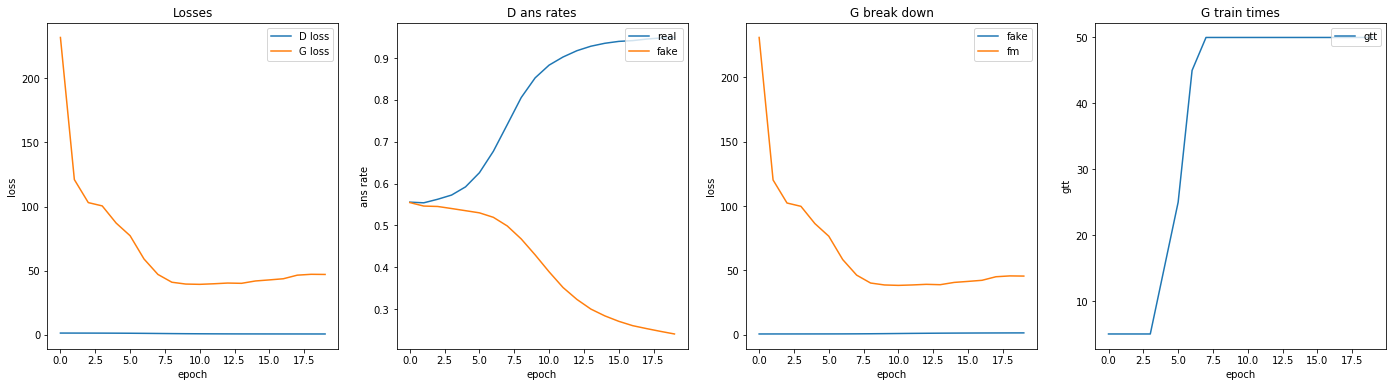

In [16]:
show_status_graph_gan_adaptive(status_dict, holizon=True, burn_in=0)

## WGAN-gpによる訓練
参考：https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py  
https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py

In [17]:
def calculate_gradient_penalty(D, real, fake, chord, gp_lambda, device):
    
    # Random Weighted AverageによりRealとFakeの中間テンソルを取得
    eta = torch.empty(len(real), 1, 1).uniform_(0, 1).to(device)
    interpolates = eta * real + ((1 - eta) * fake)
    interpolates = interpolates.requires_grad_(True)

    # 中間テンソルをDに通したテンソルを取得
    _, d_interpolates = D(interpolates, chord)

    # 勾配計算の終端へ与える値？を作成
    grad_outputs = torch.ones((len(real),)).to(device)
    grad_outputs.requires_grad = False
    
    # 勾配ペナルティの計算に使用する勾配を取得
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs, 
        create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(len(gradients), -1)

    # 勾配ペナルティの計算
    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * gp_lambda
    
    return grad_penalty



def train_wgan_gp(G, D, g_optim, d_optim, gtt, dtt, adaptive, gp_lambda, dataloader, epoch_num, output_dir, device,
              fm_lambda=None, start_epoch=1, report_period=50, clear_disp_epoch_period=3, save_epoch_period=None, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    
    current_dtt, current_gtt = dtt, gtt
    train_turn_table = np.zeros(dtt+gtt, dtype=bool)
    train_turn_table[:dtt] = True
    iteration = 0
    status_dict = { 'd_loss_real': [], 'd_loss_fake': [], 'wasserstein_d': [], 'gradient_penalty': [], 'g_loss': [] }
    
    G.train()
    D.train()

    try:
        total_d_loss_real = 0.0
        total_d_loss_fake = 0.0
        total_wasserstein_d = 0.0
        total_gp = 0.0
        total_g_loss = 0.0
        
        for epoch in range(start_epoch, epoch_num+1):
            
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            t_iter_start = time.time()
            
            for batch_iteration, batch in enumerate(dataloader, 1):
                real, chord = batch.melody.to(device), batch.chord.to(device)
                
                # Turn tableを回す
                turn = iteration % (current_dtt+current_gtt)
                iteration += 1
                
                ############
                # DのTurn
                ############
                if train_turn_table[turn]:
                    D.zero_grad()
                                        
                    with torch.set_grad_enabled(True):
                        # realデータに対するLoss
                        d_ans_real, d_loss_real = D(real, chord)
                        d_loss_real = d_loss_real.mean()
                        total_d_loss_real += d_loss_real.item()

                        # fakeデータに対するLoss
                        fake = G(chord)
                        d_ans_fake, d_loss_fake = D(fake, chord)
                        d_loss_fake = d_loss_fake.mean()
                        total_d_loss_fake += d_loss_fake.item()
                        
                        # 勾配ペナルティ
                        gradient_penalty = calculate_gradient_penalty(D, real, fake, chord, gp_lambda, device)
                        total_gp += gradient_penalty.item()

                        # DのLoss全体，および Wasserstein距離を獲得
                        d_loss = d_loss_fake - d_loss_real + gradient_penalty
                        wasserstein_d = d_loss_real - d_loss_fake
                        total_wasserstein_d += wasserstein_d.item()

                        # Dのパラメータを更新
                        d_loss.backward()
                        d_optim.step()
                    
                    if turn == current_dtt - 1:
                        # Turnの平均の記録
                        status_dict['d_loss_real'].append(total_d_loss_real / current_dtt)
                        status_dict['d_loss_fake'].append(total_d_loss_fake / current_dtt)
                        status_dict['wasserstein_d'].append(total_wasserstein_d / current_dtt)
                        status_dict['gradient_penalty'].append(total_gp / current_dtt)
                        total_d_loss_real = 0.0
                        total_d_loss_fake = 0.0
                        total_wasserstein_d = 0.0
                        total_gp = 0.0
                
                ############
                # GのTurn
                ############
                else:
                    G.zero_grad()

                    with torch.set_grad_enabled(True):
                        fake = G(chord)
                        g_ans_fake, g_loss = D(fake, chord)
                        g_loss = - g_loss.mean()
                                                
                        # Gの特徴マッチング：Gがrealに近いデータを生成できるようにする
                        # fakeデータとrealデータの違いが大きいほどペナルティを与える
                        if fm_lambda is not None:
                            mean_r = torch.mean(real, 0) # realデータの平均値
                            mean_g = torch.mean(fake, 0) # fakeデータの平均値
                            g_loss_fm = nn.MSELoss(reduction='sum')(mean_g, mean_r) / 2
                            g_loss_fm = torch.mul(g_loss_fm, fm_lambda)
                            g_loss = g_loss + g_loss_fm
                        
                        total_g_loss += g_loss.item()

                        # Gのパラメータを更新
                        g_loss.backward()                        
                        g_optim.step()
                    
                    if turn == (current_gtt + current_dtt) - 1:
                        # Turnの平均の記録
                        status_dict['g_loss'].append(total_g_loss / current_gtt)
                        total_g_loss = 0.0
                
                
                #############################
                # Adaptive WGAN-gp
                # WDに応じてturn_tableを更新
                #############################
                if adaptive and len(status_dict['wasserstein_d']) > 0:
                    last_wd = status_dict['wasserstein_d'][-1]
                    current_dtt = int(dtt * max(1 - last_wd, 1))
                    current_gtt = int(gtt * max(1 + last_wd, 1))
                    train_turn_table = np.zeros(current_dtt + current_gtt, dtype=bool)
                    train_turn_table[:current_dtt] = True

                
                ####################
                # IterationのReport
                ####################
                if (iteration % report_period == 0):
                    duration = time.time() - t_iter_start
                    print(f"Iteration {batch_iteration:>4}/{batch_num:<4} | D loss = f - r + gp: {d_loss:.4f} = {d_loss_fake:.4f} - {d_loss_real:.4f} + {gradient_penalty:.4f} | WD: {wasserstein_d:.4} | G loss: {g_loss:.4f} | dt:gt={current_dtt}:{current_gtt} | {duration:.1f} [sec]")
                    t_iter_start = time.time()



            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            
            last_d_loss_real = status_dict['d_loss_real'][-1]
            last_d_loss_fake = status_dict['d_loss_fake'][-1]
            last_wasserstein_d = status_dict['wasserstein_d'][-1]
            last_gp = status_dict['gradient_penalty'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            print(f"Epoch {epoch:>3} / {epoch_num:<3} Last Scores | D real: {last_d_loss_real:.5f} | D fake: {last_d_loss_fake:.5f} | GP: {last_gp:.5f} | WD: {last_wasserstein_d:.5f} | G loss: {last_g_loss:.5f}")
            
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]\n")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルの保存
            if (save_epoch_period is not None) and (epoch % save_epoch_period == 0):
                print("start saving models")
                save_model(config, G, epoch, output_dir)
                save_model(config, D, epoch, output_dir)
                print("")

        print("All Fine-Tuning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

訓練の実行

In [15]:
epoch_num = 500
G_trained, D_trained, status_dict = train_wgan_gp(
    G=G, D=D,
    g_optim=g_optim, d_optim=d_optim,
    gtt=config.gtt, dtt=config.dtt,
    adaptive=False, 
    gp_lambda=config.gp_lambda,
    dataloader=dataloader,
    epoch_num=epoch_num,
    output_dir=finetuned_dir,
    device=device,
    fm_lambda=config.fm_lambda,
    start_epoch=1,
    report_period=len(dataloader) // 3
)

----- Epoch 499 / 500 start -----
Iteration   83/249  | D loss = f - r + gp: -7.6451 = 0.5163 - 8.8491 + 0.6877 | WD: 8.333 | G loss: 336.4422 | dt:gt=2:5 | 16.0 [sec]
Iteration  166/249  | D loss = f - r + gp: -7.5922 = 0.3405 - 8.9755 + 1.0428 | WD: 8.635 | G loss: 302.1771 | dt:gt=2:5 | 16.0 [sec]
Iteration  249/249  | D loss = f - r + gp: -7.7536 = 0.3390 - 8.9189 + 0.8263 | WD: 8.58 | G loss: 305.0857 | dt:gt=2:5 | 15.6 [sec]
Epoch 499 / 500 finished in 47.7775[sec]
Epoch 499 / 500 Last Scores | D real: 8.99255 | D fake: 0.34489 | GP: 0.91156 | WD: 8.64766 | G loss: 315.62260
Remaining Time | 0.0133 [hour] | 0.80 [min] | 48 [sec]

----- Epoch 500 / 500 start -----
Iteration   83/249  | D loss = f - r + gp: -7.4287 = 0.5461 - 8.9493 + 0.9744 | WD: 8.403 | G loss: 306.8499 | dt:gt=2:5 | 15.8 [sec]
Iteration  166/249  | D loss = f - r + gp: -7.8013 = 0.3928 - 9.0146 + 0.8205 | WD: 8.622 | G loss: 348.9957 | dt:gt=2:5 | 16.0 [sec]
Iteration  249/249  | D loss = f - r + gp: -7.8198 = 0

Statusグラフの表示

In [16]:
def show_status_graph_wgan_gp(status_dict, title="Score graphs of WGAN-gp"):
    d_loss_real = status_dict['d_loss_real']
    d_loss_fake = status_dict['d_loss_fake']
    wasserstein_d = status_dict['wasserstein_d']
    gradient_penalty = status_dict['gradient_penalty']
    g_loss = status_dict['g_loss']
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    
    x = np.arange(len(d_loss_real))
    axs[0].plot(x, d_loss_real, label='real_loss', linewidth=1.5)
    axs[0].plot(x, d_loss_fake, label='fake_loss', linewidth=1.5)
    axs[0].plot(x, gradient_penalty, label='gp', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('turn')
    axs[0].set_ylabel('costs')
    axs[0].set_title(f"D costs")

    axs[1].plot(x, wasserstein_d, label='wasserstein_d', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('turn')
    axs[1].set_ylabel('wasserstein_d')
    axs[1].set_title(f"Wasserstein distance")
    
    x = np.arange(len(g_loss))
    axs[2].plot(x, g_loss, label='loss', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('turn')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G loss")

    plt.show()

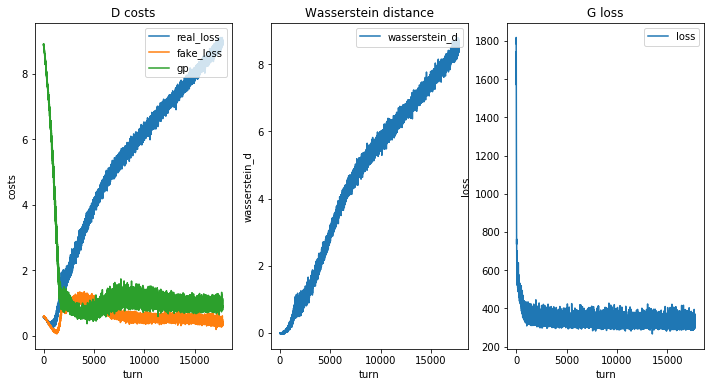

In [17]:
show_status_graph_wgan_gp(status_dict)

記念すべき初回実行  
とりあえず学習済みのbase  
ロクなものではない  
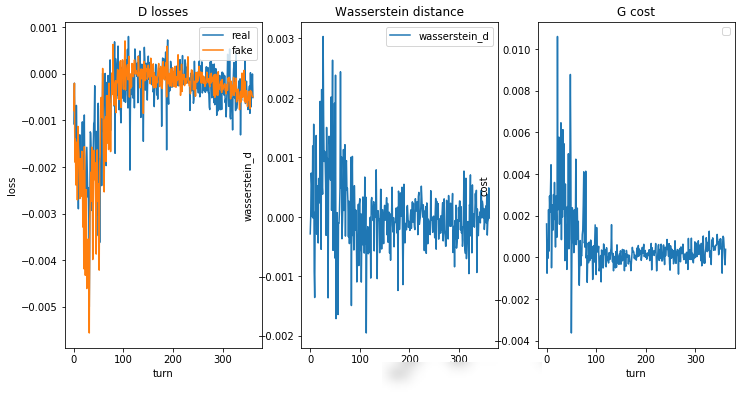

学習しないでやってみた場合  
WDがほぼ0だったりマイナスになったり，謎現象発生中  
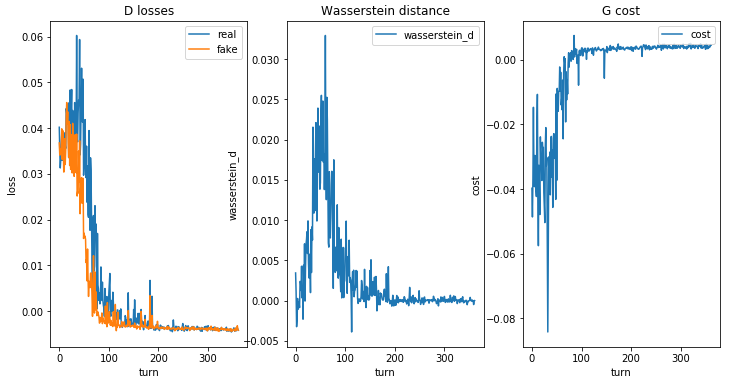

プログラム直してみたらWDの値とかが良い感じになった．  
しかしD強め？みたいなのでgtt3くらいにしてみるか？  
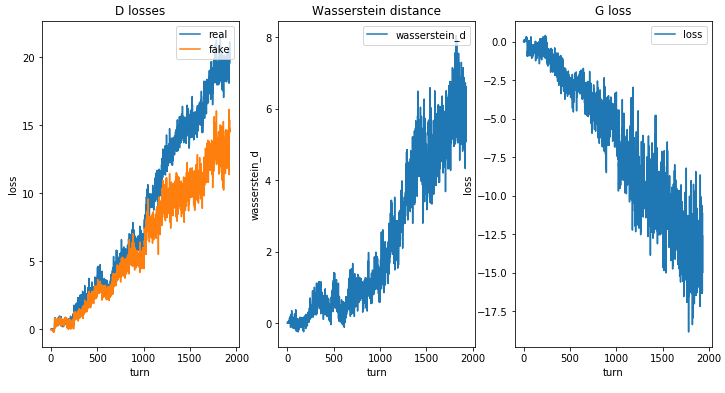

さらにMNP＋MSPの事前学習済みモデルをそのまま使えるようにしたバージョン  
全然Convergeしない．．．  
チューニング実験しながら論文読むか．．．  
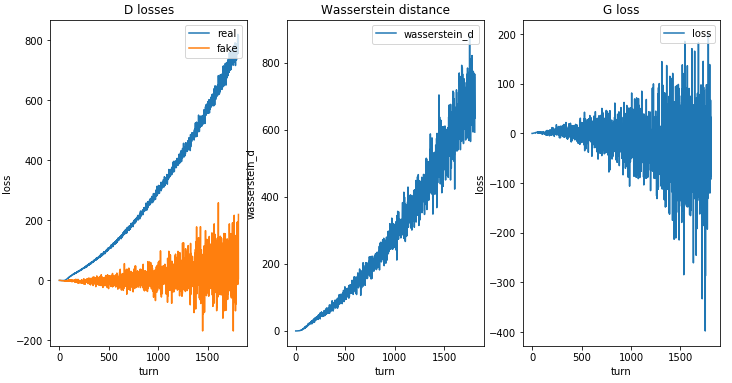

100エポックの出力結果消えた．．．でもまぁこんな感じ  
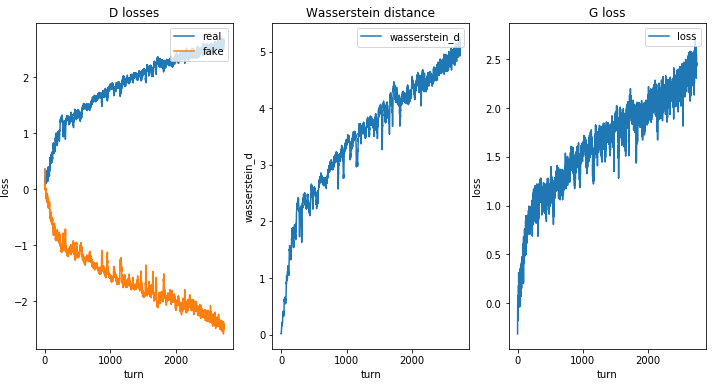

dtt:gtt = 2:5  
ほとんどが音程番号12になるというモード崩壊？が発生  
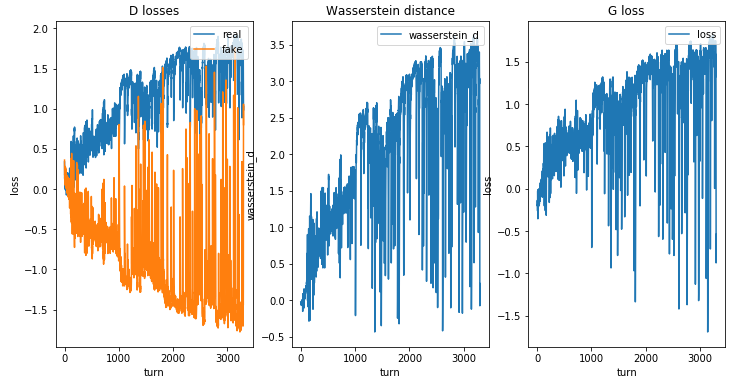

2:5の線形Adaptiveで200epoch  
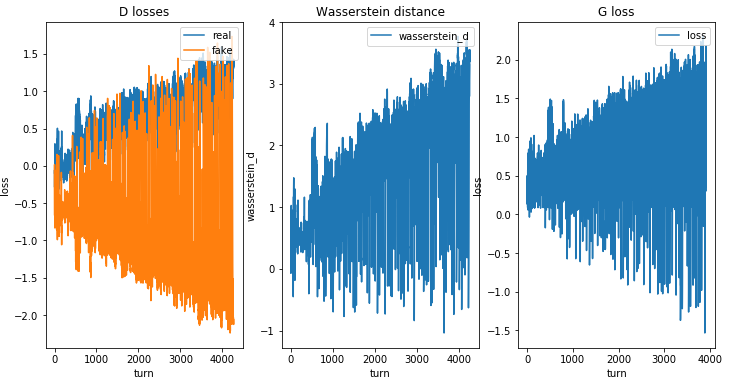

Adaptiveやめてみて，かつGの出力を全てone-hotにしてGPを出してみた  
これはもう何が悪いんだか...  
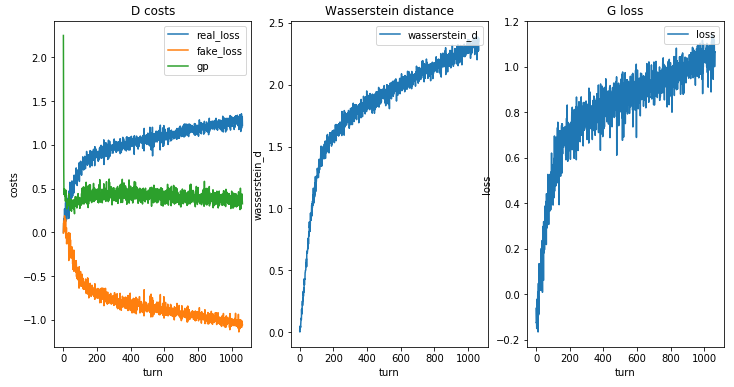

色々直して再挑戦したが，fm lossも小さくならないし...  
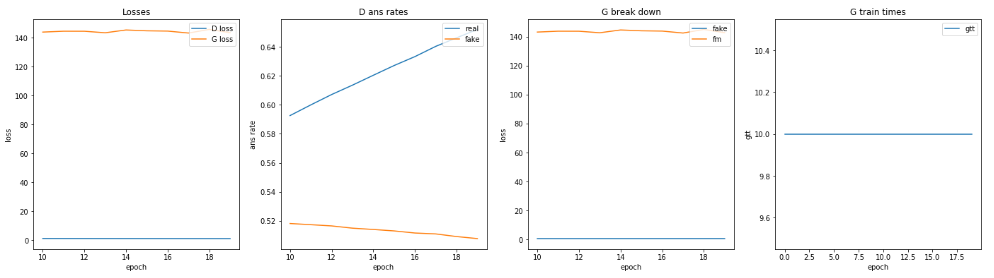

LightでWGAN-gp  
生成もCしか出さない...  
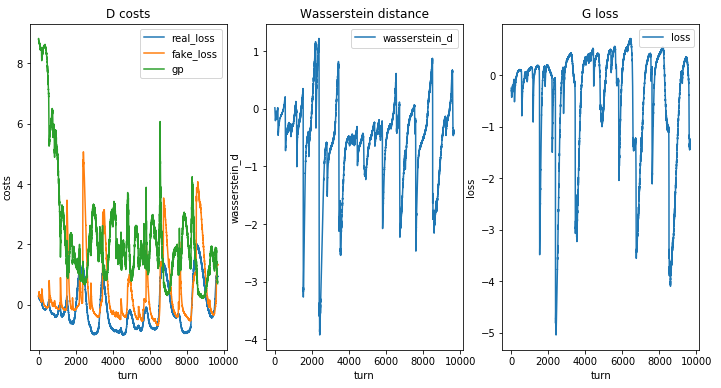

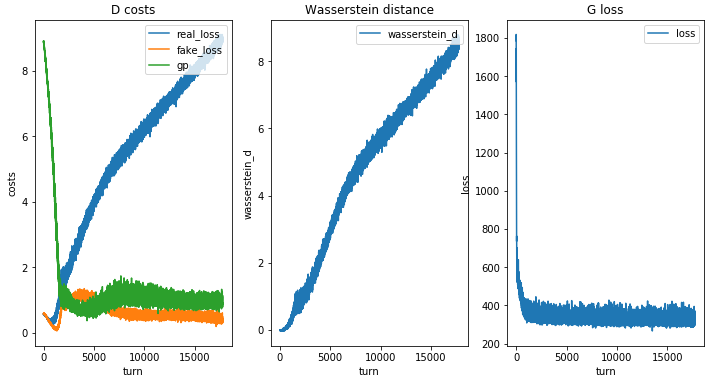

Adaptive GTT GANでもきれいに負ける  
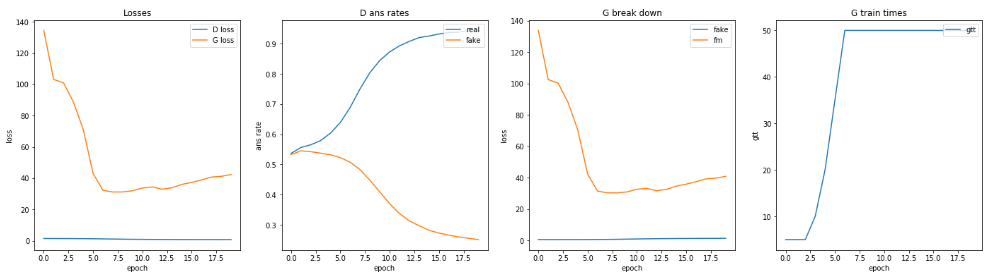

乱数が多すぎるのではと思い全てのステップを同じにしてみたけど何も変わらない  
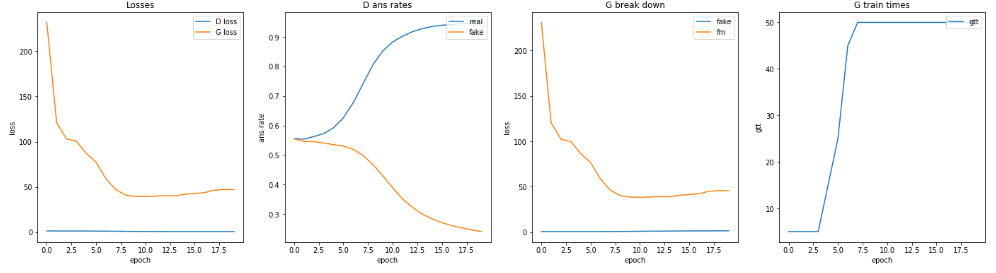

生成データの確認

In [17]:
batch = dataloader()
g_out = G_trained(batch.chord.to(device))
g_melody = G.to_melody(g_out)

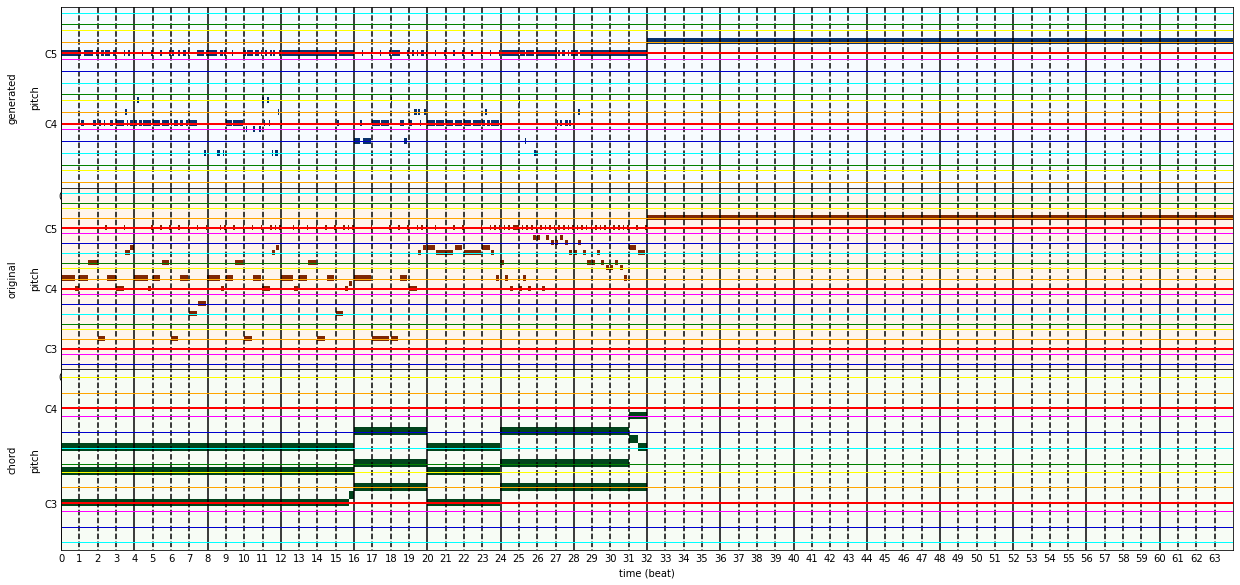

In [20]:
batch_id = 2

bundle = Bundle({
    'melody': g_melody[batch_id],
    'chord': batch.chord[batch_id].numpy(),
    'meta': batch.meta[batch_id]
})
bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
ppr = bundle.get_ppr()

org_bundle = Bundle({
    'melody': batch.melody[batch_id].numpy(),
    'chord': batch.chord[batch_id].numpy(),
    'meta': batch.meta[batch_id]
})
org_bundle.meta.melody_pitch_range = [0, config.melody_vocab_size]
org_ppr = org_bundle.get_ppr()
ppr.tracks.insert(1, org_ppr.tracks[0])

ppr.tracks[0].name = "generated"
ppr.tracks[1].name = "original"
grid_plot(ppr, beat_resolution=bundle.meta.beat_resolution)

初回実行ではこんな感じか…  
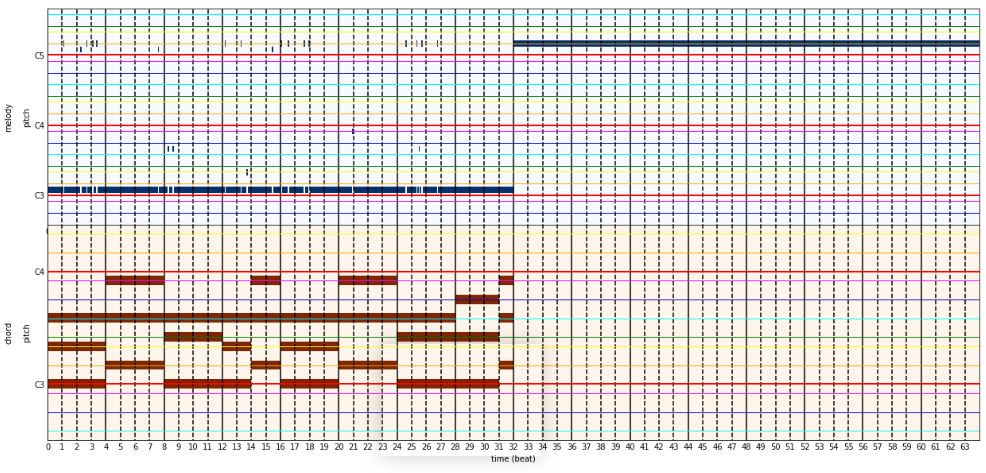

まぁ学習あったほうがバラバラにはならないみたいね  
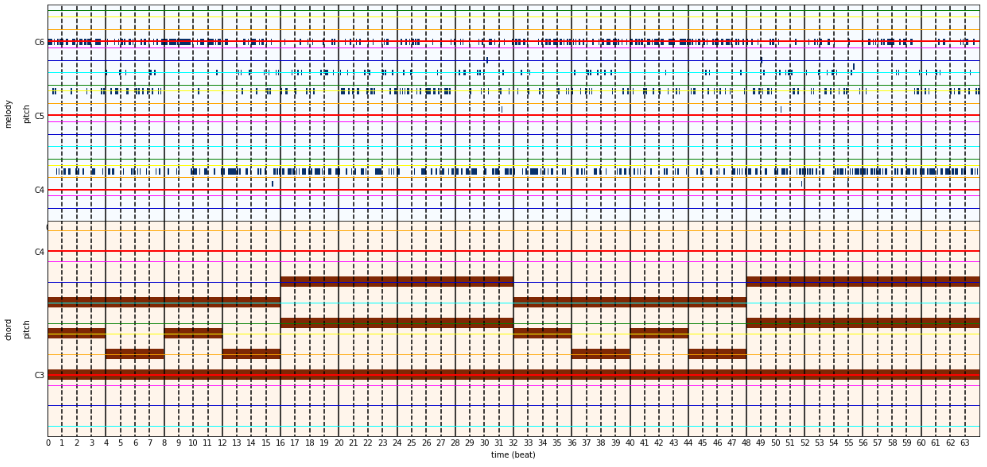

MNP+MSPで100エポック回してみた結果  
WDは全然収束してないけど，繰り返しは捉えられている  
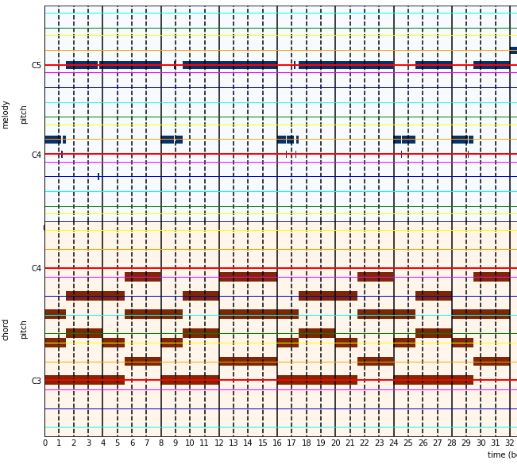

PADDINGがちゃんとなってない  
どっかにバグがあるはず  
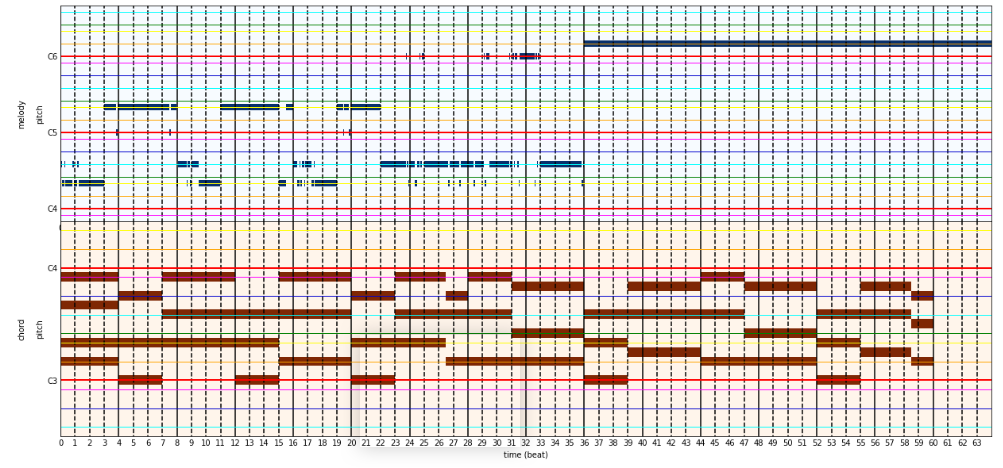

これもPADDINGちゃんとなってない，  
しかし，長期にわたる繰り返しを捉えられていることが分かる  
a/aretha-franklin/i-say-a-little-prayer/chorus_key.mid
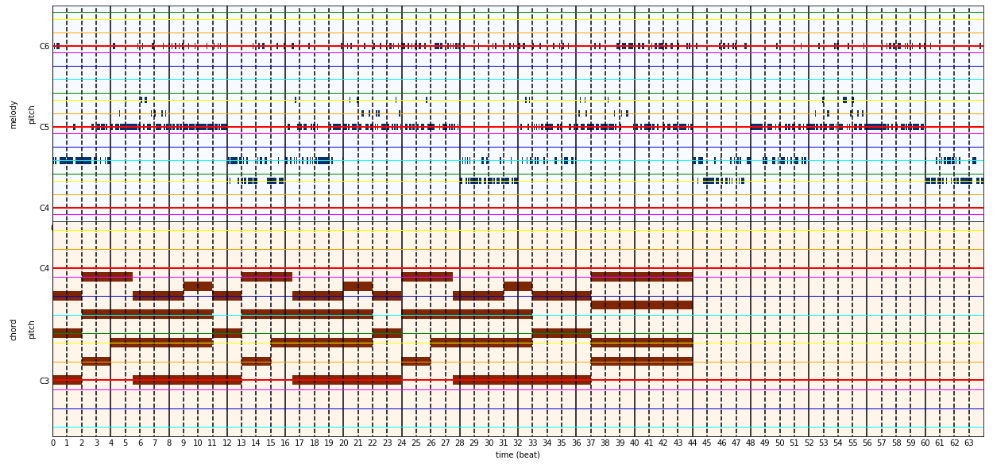

g/ginuwine/pony/chorus_key.midの生成結果  
繰り返しは捉えられていても，もしかしてコードの前処理が上手くいってない？  
いや，コードの前処理はうまくいってる．  
モデル内でのPADDINGの扱いが上手くいってない説  
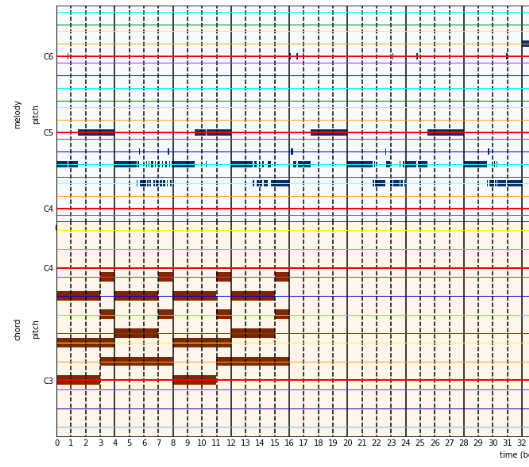

Adaptive GTT GANで20 Epoch  
少ないエポック数にも関わらず結構いい感じ  
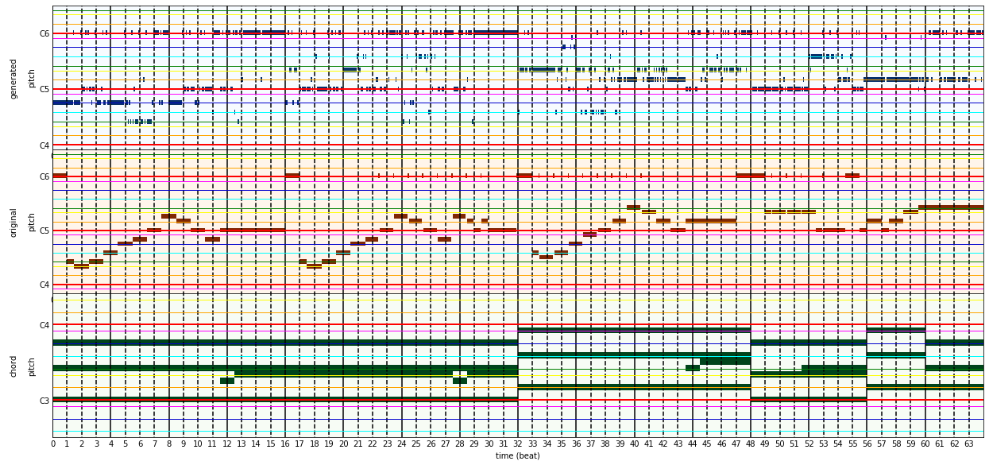

繰り返し？も一応出てる  
あとは高速化したい  
休符若干多めなのとボロボロなのは高速化してEpoch稼げば行けそう？  
やっぱりAdaptive GTT強いな  
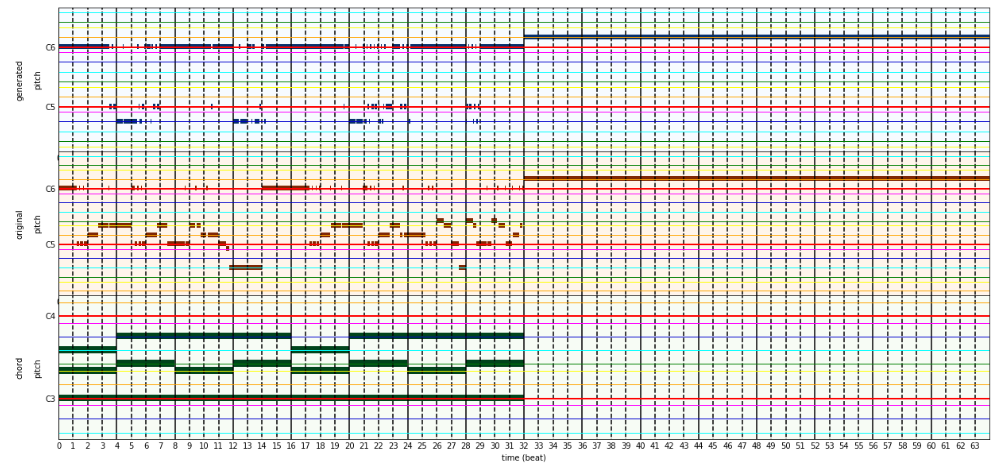

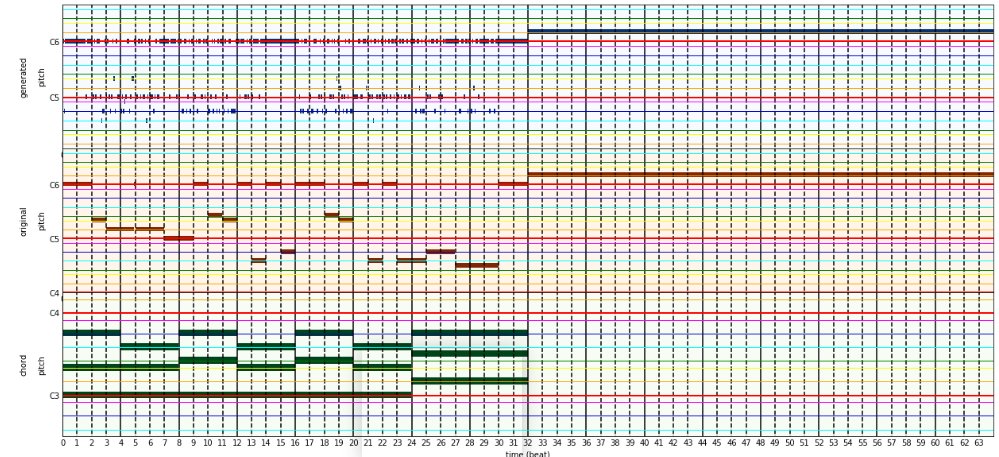

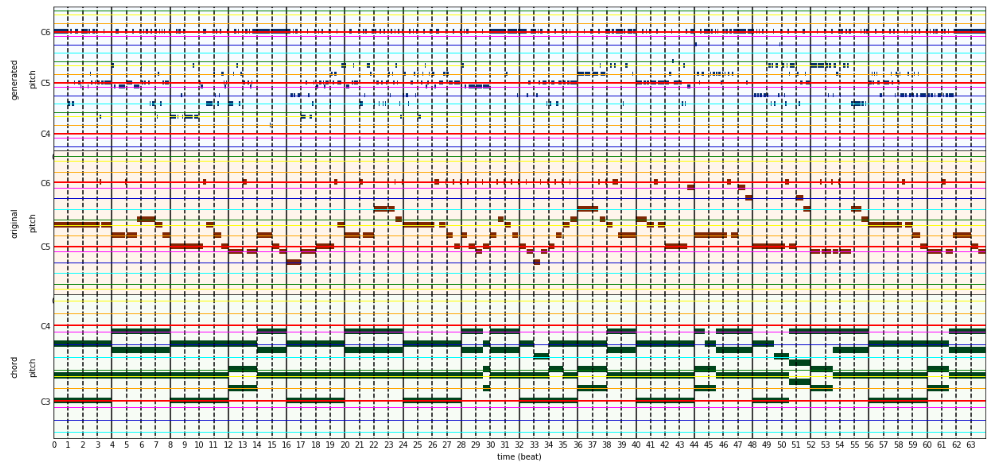

全てのステップのノイズを同じにしてみたらこれと同じような出力しか得られなくなった  
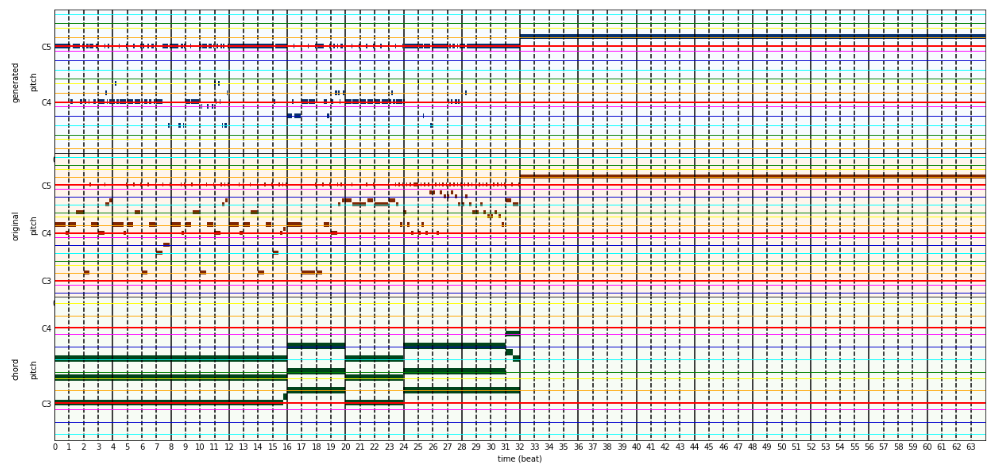

## ファインチューニング済みモデルの保存と読込み

In [20]:
# epoch_num = 50
state_names_dict = {
    'G': save_model(config, G_trained, epoch_num, finetuned_dir),
    'D': save_model(config, D_trained, epoch_num, finetuned_dir)
}
config_file_name = save_config(config, finetuned_dir, state_names_dict=state_names_dict)

schbertgan_small:SchWBertGenerator:E=500H=128I=512A=2AH=1.pth saved
schbertgan_small:SchWBertDiscriminator:E=500H=128I=512A=2AH=1.pth saved
schbertgan_small:config@2019-12-17_11:39.json saved


読込みはココから

In [ ]:
config = select_config(finetuned_dir, fixed_number=None)

In [ ]:
dataset = TheorytabDataset(bundle_list)
dataloader = TheorytabDataLoader(dataset, batch_size=2, shuffle=True)
print(len(dataloader))

In [ ]:
def load_gan(config, directory, device=None, multi_gpu=False, d_is_light=False):
    if device is None:
        device = torch.device('cpu')
    
    G = SchWBertGenerator(config, make_body(config))
    if d_is_light:
        D = SchWBertDiscriminatorLight(config, make_body(config))
    else:
        D = SchWBertDiscriminator(config, make_body(config))
    G_trained = load_model(G, config.state_names.G, directory).to(device)
    D_trained = load_model(D, config.state_names.D, directory).to(device)
    
    if multi_gpu:
        G_trained, D_trained = MultiGPUWrapper(G_trained), MultiGPUWrapper(D_trained)
        
    return G_trained, D_trained

In [ ]:
device = torch.device('cuda')
G_trained, D_trained = load_gan(config, finetuned_dir, device=device, d_is_light=True)

生成実験は上に行ってね

### Adaptive WGAN-gpの学習回数グラフ

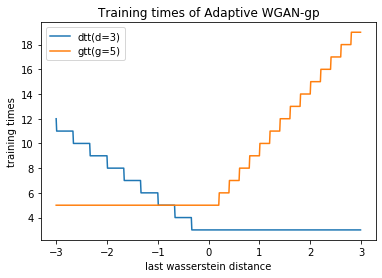

In [18]:
dtt, gtt = 3, 5
last_wds = np.arange(-3, 3, 0.01)
dtts = dtt * np.clip(1 - last_wds, 1, None)
gtts = gtt * np.clip(1 + last_wds, 1, None)
dtts, gtts = dtts.astype(int), gtts.astype(int)

plt.plot(last_wds, dtts, label=f"dtt(d={dtt})")
plt.plot(last_wds, gtts, label=f"gtt(g={gtt})")
plt.title("Training times of Adaptive WGAN-gp")
plt.xlabel("last wasserstein distance")
plt.ylabel("training times")
plt.legend()
plt.show()

## 考察

Adaptiveしてもビクともしない感じ  
ひょっとしてBERTは大域的な情報を考慮できても局所的な情報に弱い？  
BERTは遠くの情報を考慮できる一方，近くにあるものと遠くにあるものを同様に扱いがちなのかもしれない  
しかし大域的な情報は利用したい．  
そこで，MidiNetのようなCNNベースのモデルにBERTを織り込むことを考える  
局所的な畳み込みを行いつつ，畳み込みの各段階でBERTを通して大域的な情報を考慮させる  